# kubectl top stats (.csv) file analysis notebook
- copy the kube-top-stats .csv file to the docker mounted volume which is the directory from where you started this container
  
- make sure we have column header name as the 1st row in the below order _timeStamp,nameSpace,podName,containerName,cpuRequest,cpuUsage,memRequest,memUsage,cpuLimit,memLimit_

> *Dataframe is sensitive to whitespaces, make sure in the label and other places there are not leading/trailing whitespaces at all*


In [ ]:
import pandas as pd
import seaborn.objects as so
import seaborn as sns

file_path = '/home/ubuntu/work/kube-top-stats.csv'
df = pd.read_csv(file_path)

df['timeStamp'] = pd.to_datetime(df['timeStamp'], format='%Y-%m-%dT%H:%M:%S')

# filter out with pod name
# df_filtered = df[df.podName.str.match('kafka-0.*',na=False)]
df_filtered = df[df.podName.str.match('.*',na=False)]

# generate a new column cpuBurstPct & memBurstPct - burstable QoS
df_filtered ['cpuBurstPct'] = 100*df_filtered['cpuLimit']/df_filtered['cpuRequest']
df_filtered ['memBurstPct'] = 100*df_filtered['memLimit']/df_filtered['memRequest']

# generate a new column cpuOveragePct & memOveragePct
df_filtered ['cpuOveragePct'] = 100*df_filtered['cpuUsage']/df_filtered['cpuRequest']
df_filtered ['memOveragePct'] = 100*df_filtered['memUsage']/df_filtered['memRequest']


## Total sampling duration

In [ ]:
df.reset_index().set_index('timeStamp',inplace=True)
print (df.timeStamp.iloc[-1] -df.timeStamp.iloc[0])

## CPU/mem allocation summary
breakup by container name

In [ ]:
# QoS - bursting headroom in %, which is calculated from the limit and request setting of the container
df_filtered.groupby('containerName')['memBurstPct'].max ()

In [ ]:
# QoS - bursting headroom in %, which is calculated from the limit and request setting of the container
df_filtered.groupby('containerName')['cpuBurstPct'].max ()

## CPU/mem utilization summary in micore, MiB
breakup by container name

In [ ]:
# container level mem utilization metric
df_filtered.groupby('containerName')['memUsage'].describe (percentiles =[.5, .9, .95, .99])

In [ ]:
# container level cpu utilization metric
df_filtered.groupby('containerName')['cpuUsage'].describe (percentiles =[.5, .9, .95, .99])

## CPU/mem overage as % of containers.resources.requests.memory/cpu
breakup by container name

In [ ]:
# container level mem utilization overage %
df_filtered.groupby('containerName')['memOveragePct'].describe (percentiles =[.5, .9, .95, .99])

In [ ]:
# container level cpu utilization overage %
df_filtered.groupby('containerName')['cpuOveragePct'].describe (percentiles =[.5, .9, .95, .99])

## Downsampling cpuUsage, memUsage, cpuOveragePct, memOveragePct filter by a specific container
5 sec interval with aggregation function max applied

<Axes: xlabel='timeStamp'>

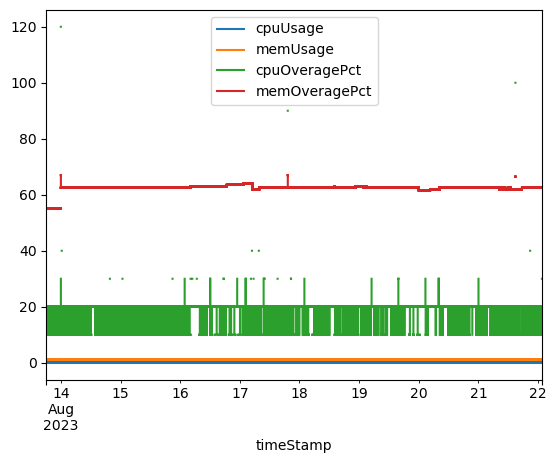

In [180]:
# convert the index to DatetimeIndex from RangeIndex for aiding with downsampling etc
#df_downsample = df_filtered.copy()
df_downsample = df_filtered[df_filtered.podName.str.match('.*kafka.*',na=False)]
df_downsample.set_index('timeStamp',inplace=True)

# agg 5sec
df_downsample = df_downsample[["cpuUsage","memUsage","cpuOveragePct", "memOveragePct"]].resample("5s").max()
# agg daily
#df_downsample = df_downsample[["cpuUsage","memUsage","cpuOveragePct", "memOveragePct"]].resample("1D").max()

df_downsample.plot()

## Pivot table cpuUsage, splitup by pod name & container name
Aggregation max/min/mean/count

In [ ]:
p_table = pd.pivot_table( data=df_filtered, 
                        index=['podName'], 
                        columns=['containerName'], 
                        values='cpuUsage',
                        aggfunc=['max','min', 'mean', 'count'],
                        fill_value="None")

p_table
#p_table[p_table["cpuUsage"] > 5000]